# 전복데이터 LSTM 회귀
______
## 1. 데이터 준비

In [23]:
# 데이터 불러오기
import pandas as pd

df = pd.read_csv(r"C:\Users\DoHyeonjik\GachonUniv\3-2\datasets\DL\abalone.csv")
print(df)

        id Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0        0   M   0.455     0.365   0.095        0.5140          0.2245   
1        1   M   0.350     0.265   0.090        0.2255          0.0995   
2        2   F   0.530     0.420   0.135        0.6770          0.2565   
3        3   M   0.440     0.365   0.125        0.5160          0.2155   
4        4   I   0.330     0.255   0.080        0.2050          0.0895   
...    ...  ..     ...       ...     ...           ...             ...   
4172  4172   F   0.565     0.450   0.165        0.8870          0.3700   
4173  4173   M   0.590     0.440   0.135        0.9660          0.4390   
4174  4174   M   0.600     0.475   0.205        1.1760          0.5255   
4175  4175   F   0.625     0.485   0.150        1.0945          0.5310   
4176  4176   M   0.710     0.555   0.195        1.9485          0.9455   

      Viscera_weight  Shell_weight  Rings  
0             0.1010        0.1500     15  
1             0.0485   

In [24]:
# 열 데이터 알아보기
print(df.columns)
# 전복데이터 구조
print(df.shape)

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
       'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')
(4177, 10)


## 2. 데이터 전처리

In [25]:
# 텍스트로 구성된 Sex 특성을 수치값으로 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['Sex'])
df['Sex'] = le.transform(df['Sex'])
print(df['Sex'])

0       2
1       2
2       0
3       2
4       1
       ..
4172    0
4173    2
4174    2
4175    0
4176    2
Name: Sex, Length: 4177, dtype: int32


In [26]:
# 데이터와 레이블 분리
df_label = df['Rings']
df_data = df.drop(['id','Rings'], axis=1)
print(df_data.shape)
print(df_label.shape)

(4177, 8)
(4177,)


In [27]:
# # 훈련데이터와 테스트 데이터로 분리
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(df_data, df_label, random_state=42)
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

In [28]:
# split_sequence 함수 적용을 위해 훈련 세트와 테스트세트를 병합
import numpy as np

y_train = np.array(y_train)
train_set = np.c_[x_train, y_train]

y_test = np.array(y_test)
test_set = np.c_[x_test, y_test]

print(train_set.shape)
print(test_set.shape)

(3132, 9)
(1045, 9)


In [31]:
# split_sequence 함수
from collections import Counter

def split_sequence(sequences, n_steps):
    x, y = list(), list()
    for i in range(len(sequences)):
        end_idx = i + n_steps
        if end_idx > len(sequences):
            break

        seq_x = sequences[i:end_idx, :-1]
        seq_y_values = sequences[i:end_idx, -1]

        most_common_values = Counter(seq_y_values).most_common(1)[0][0]
        x.append(seq_x)
        y.append(most_common_values)

    return np.array(x), np.array(y)    

In [32]:
n_steps= 5

x_train_seq, y_train_seq = split_sequence(train_set, n_steps)
x_test_seq, y_test_seq = split_sequence(test_set, n_steps)

print(x_train_seq.shape, y_train_seq.shape)
print(x_test_seq.shape, y_test_seq.shape)

(3128, 5, 8) (3128,)
(1041, 5, 8) (1041,)


## 3. 모델생성 및 훈련

In [35]:
from tensorflow import keras
from keras.layers import LSTM, Dense
from keras.models import Sequential

model = Sequential()

model.add(LSTM(128, input_shape=(5,8)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,785 (339.00 KB)

 Trainable params: 86,785 (339.00 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(x_train_seq, y_train_seq, epochs= 20, batch_size=32, validation_split=0.1, shuffle=True)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 43.3847 - mae: 5.2778 - val_loss: 5.7567 - val_mae: 1.6858
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4621 - mae: 1.8070 - val_loss: 5.4679 - val_mae: 1.6775
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3944 - mae: 1.7900 - val_loss: 6.6356 - val_mae: 1.7404
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8747 - mae: 1.7174 - val_loss: 5.3742 - val_mae: 1.6876
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5678 - mae: 1.8392 - val_loss: 5.5864 - val_mae: 1.6395
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0233 - mae: 1.7436 - val_loss: 5.4756 - val_mae: 1.6575
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1999 - mae: 1.7701 - val_loss: 5.3303 - val_mae: 1.6742
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3872 - mae: 1.8224 - val_loss: 5.4227 - val_mae: 1.6385
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2713 - mae:

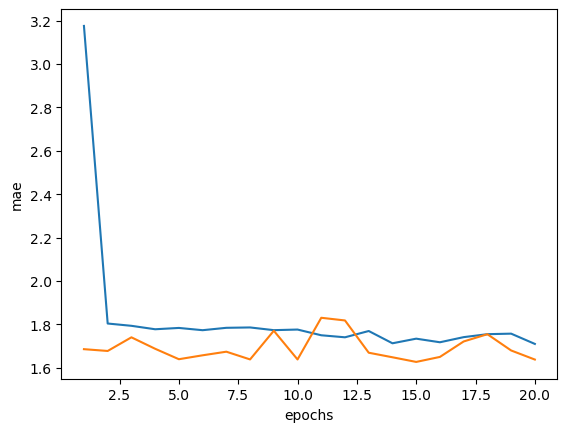

In [37]:
import matplotlib.pyplot as plt


mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae)+1)
plt.plot(epochs, mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.show()

In [40]:
print(model.evaluate(x_test_seq, y_test_seq))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3400 - mae: 1.5883
[4.6810712814331055, 1.5657145977020264]
